# Введение в искусственные нейронные сети

# Урок 6. Сегментация

# <font color='blue'>Практическое задание</font>

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. <br>
2. Опишите результат. Что помогло вам улучшить ее точность?


### Используемый dataset - https://www.kaggle.com/dansbecker/cityscapes-image-pairs

In [1]:
import zipfile  # библиотека для работы с zip-архивами
import os  # работа с файловой системой
import time

from google.colab import drive  # Модуль для работы с Google Disc
from PIL import Image  # Модуль для работы с изображениями

## Использование Google Drive

Подключение Google Drive к виртуальной машине:

In [3]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Просматриваем подключенные диски

In [4]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   43G   37G  54% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  817M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1        86G   47G   40G  55% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  2.7G   13G  18% /content/gdrive


In [5]:
# Просматриваем содержимое диска
!ls /content/gdrive/

MyDrive


In [12]:
!ls /content/gdrive/"MyDrive"/nn

lesson_6


In [13]:
!cp /content/gdrive/"MyDrive"/nn/lesson_6/cityscapes_data.zip .

In [14]:
!ls

cityscapes_data.zip  gdrive  sample_data


In [15]:
zip_file = "cityscapes_data.zip"
# Распаковываем архив

!unzip '/content/cityscapes_data.zip' -d '/content/data'

Archive:  /content/cityscapes_data.zip
  inflating: /content/data/cityscapes_data/train/1.jpg  
  inflating: /content/data/cityscapes_data/train/10.jpg  
  inflating: /content/data/cityscapes_data/train/100.jpg  
  inflating: /content/data/cityscapes_data/train/1000.jpg  
  inflating: /content/data/cityscapes_data/train/1001.jpg  
  inflating: /content/data/cityscapes_data/train/1002.jpg  
  inflating: /content/data/cityscapes_data/train/1003.jpg  
  inflating: /content/data/cityscapes_data/train/1004.jpg  
  inflating: /content/data/cityscapes_data/train/1005.jpg  
  inflating: /content/data/cityscapes_data/train/1006.jpg  
  inflating: /content/data/cityscapes_data/train/1007.jpg  
  inflating: /content/data/cityscapes_data/train/1008.jpg  
  inflating: /content/data/cityscapes_data/train/1009.jpg  
  inflating: /content/data/cityscapes_data/train/101.jpg  
  inflating: /content/data/cityscapes_data/train/1010.jpg  
  inflating: /content/data/cityscapes_data/train/1011.jpg  
  inflat

In [16]:
!pwd

/content


# Работа с изображением

(256, 512, 3)
2975


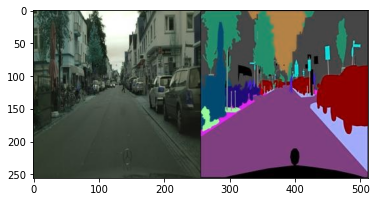

In [61]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

path_train = '/content/data/cityscapes_data/train/'
img1 = cv2.imread(path_train, 0)

file_train_list = os.listdir(path_train)
img0 = cv2.imread(path_train + file_train_list[0])
plt.imshow(img0)
print(np.shape(img0))
print(len(file_train_list))

# Чтение картинок и формирование тренировочного датасета

In [62]:
szy, szx, _ = np.shape(img0)
N_ex = 500  # при 1500 - colab отключается, исчерпан лимит памяти
N_bias = 0
x_train = np.zeros((N_ex, szy, int(szx/2),3))
y_train = np.zeros((N_ex, szy, int(szx/2),3))
k = 0;

for f in file_train_list[N_bias:N_bias + N_ex]:
    x_train[k] = cv2.imread(path_train + f)[:,:256]/256
    y_train[k] = cv2.imread(path_train + f)[:,256:]/256
    k = k + 1

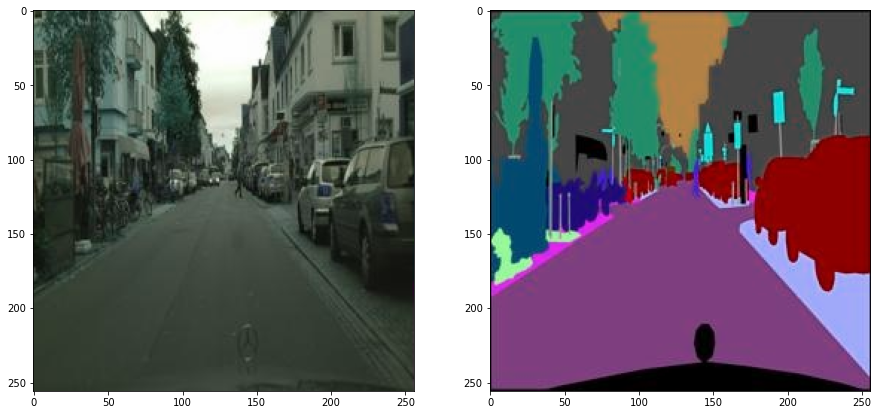

In [63]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(y_train[0])

# Аналогично подготавливаем тестовый дата сет

(256, 512, 3)
500


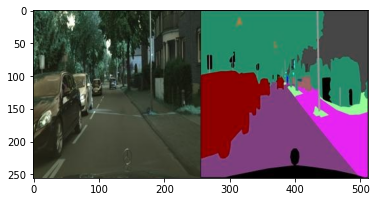

In [64]:
path_val = '/content/data/cityscapes_data/val/'
img1 = cv2.imread(path_val, 0)

file_val_list = os.listdir(path_val)
img0 = cv2.imread(path_val + file_val_list[0])
N_val = 50

plt.imshow(img0)
print(np.shape(img0))
print(len(file_val_list))

In [65]:
szy, szx, _ = np.shape(img0)
x_val = np.zeros((N_val, szy, int(szx/2),3))
y_val = np.zeros((N_val, szy, int(szx/2),3))
k = 0;

for f in file_val_list[0:N_val]:
    x_val[k] = cv2.imread(path_val + f)[:,:256]/256
    y_val[k] = cv2.imread(path_val + f)[:,256:]/256
    k = k + 1

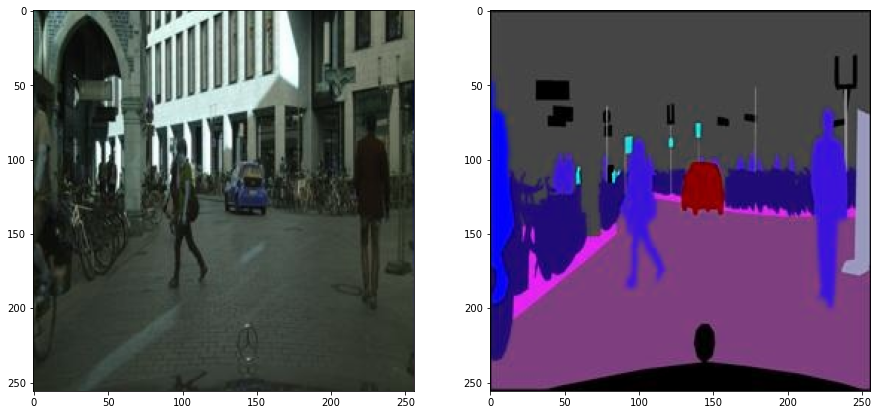

In [66]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_val[1])
plt.subplot(1,2,2)
plt.imshow(y_val[1])

# U-net architecture

![title](U-net.png)

In [67]:
# U-net architecture
import tensorflow as tf
import keras
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import BatchNormalization
# from keras.layers import Input, Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
# from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, Conv2D

from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from keras.layers import (Input, Dense, Dropout, Activation, Flatten, Convolution2D, 
                          MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate)
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam


import keras.backend as K  # !!!

# Это наша метрика на Tensorflow
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [68]:
def Unet(num_classes = 14, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D()(block_2_out) #

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D()(block_3_out) #

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # Растягиваем картинку
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # конкатенируем то что получили после 3-го увеличения и блок 3
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # # UP 4
    # x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    # x = concatenate([x, block_1_out])
    # x = Conv2D(64, (3, 3), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # x = Conv2D(64, (3, 3), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # слой классификатор (14 классов)
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    # model.compile(optimizer=Adam(),
    #               loss='categorical_crossentropy',
    #               metrics=[dice_coef])
    # model.summary()
    return model

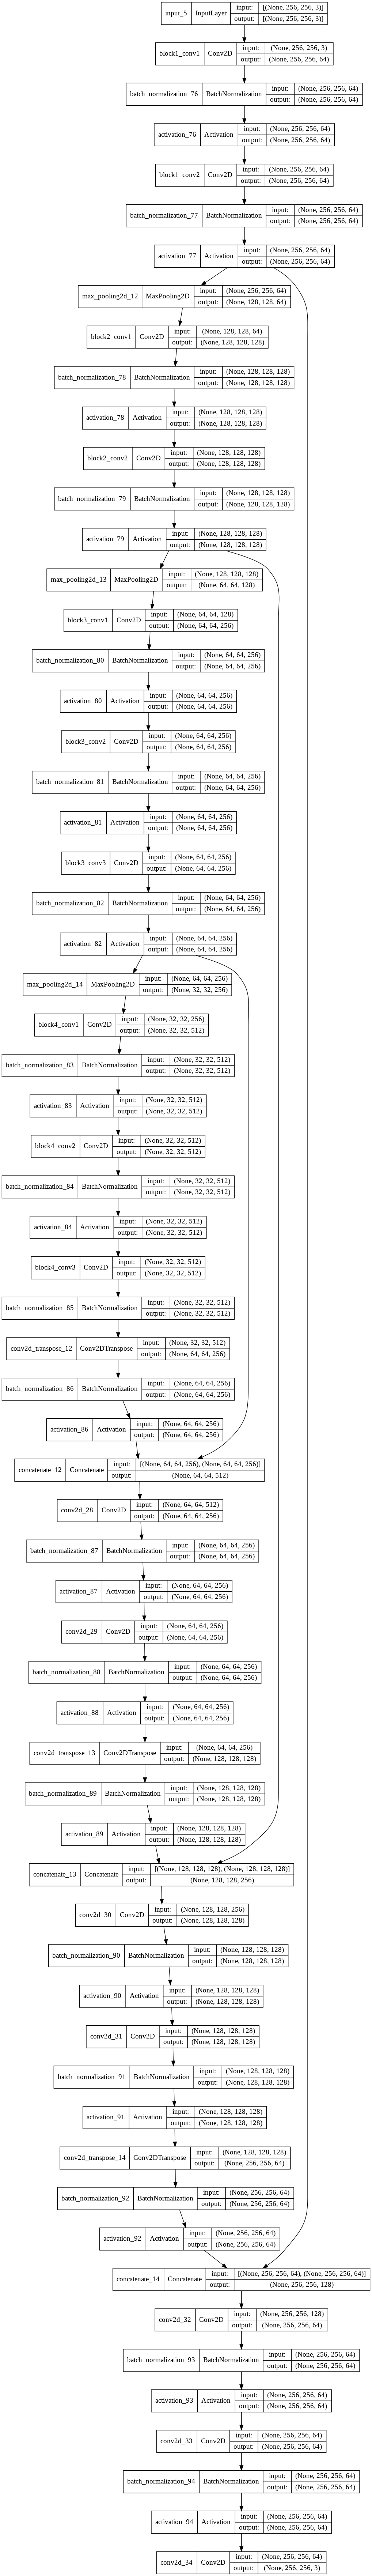

In [69]:
modelC = Unet(3, (256, 256, 3))

# plot_model(modelC, to_file='modelC.png')
plot_model(modelC, to_file='modelC.png', show_shapes=True)

In [70]:
modelC.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
modelC.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_76 (BatchN  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [71]:
history = modelC.fit(x_train, y_train,
                     epochs=25,
                     batch_size=10,
                     validation_data=(x_val, y_val)
                     )

Epoch 1/25
50/50 [==============================] - 31s 575ms/step - loss: 1.1620 - dice_coef: 0.3618 - val_loss: 6.1119 - val_dice_coef: 0.3513
Epoch 2/25
50/50 [==============================] - 29s 581ms/step - loss: 1.1372 - dice_coef: 0.3579 - val_loss: 1.1457 - val_dice_coef: 0.3477
Epoch 3/25
50/50 [==============================] - 29s 588ms/step - loss: 1.1363 - dice_coef: 0.3592 - val_loss: 1.3210 - val_dice_coef: 0.3589
Epoch 4/25
50/50 [==============================] - 30s 594ms/step - loss: 1.1366 - dice_coef: 0.3600 - val_loss: 1.2466 - val_dice_coef: 0.3580
Epoch 5/25
50/50 [==============================] - 30s 597ms/step - loss: 1.1389 - dice_coef: 0.3602 - val_loss: 1.1803 - val_dice_coef: 0.3497
Epoch 6/25
50/50 [==============================] - 30s 593ms/step - loss: 1.1385 - dice_coef: 0.3604 - val_loss: 1.3006 - val_dice_coef: 0.3625
Epoch 7/25
50/50 [==============================] - 30s 603ms/step - loss: 1.1399 - dice_coef: 0.3617 - val_loss: 1.2298 - val_dic

In [72]:
pred = modelC.predict(x_val)
print(pred.shape)

(50, 256, 256, 3)


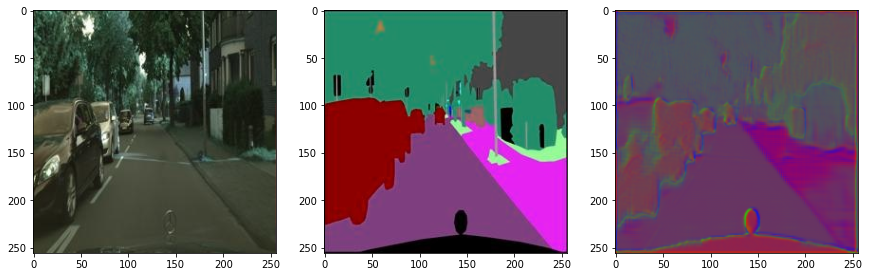

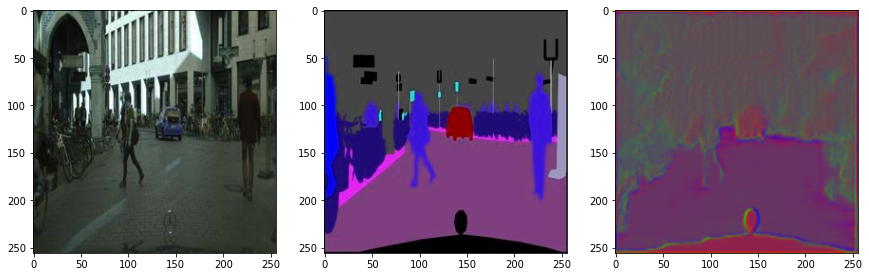

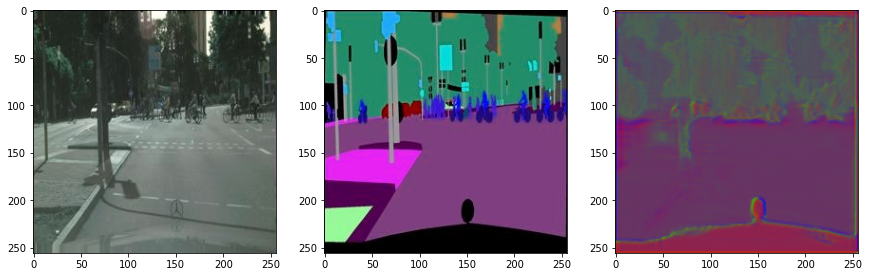

In [73]:
n = 3
for k in range(n):
    plt.figure(figsize=(20, 60))

    plt.subplot(n, 4, 1 + k*4)
    plt.imshow(x_val[k])

    plt.subplot(n, 4, 2 + k*4)
    plt.imshow(y_val[k])

    plt.subplot(n, 4, 3 + k*4)
    plt.imshow(pred[k])

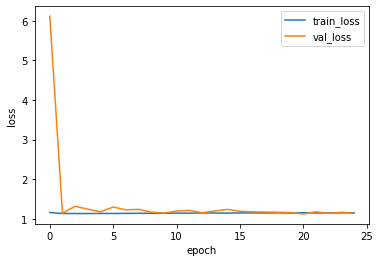

In [74]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

После 5 эпохи потери на тестовой выборке практически не меняется.

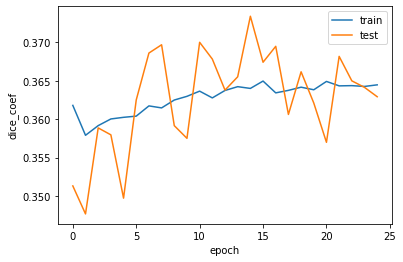

In [75]:
plt.plot(history.history['dice_coef'], label='train')
plt.plot(history.history['val_dice_coef'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Как на тестовой, так и на тренировочной выборках изменение dice_coef с увеличением числа эпох меняется незначительно.

### Вывод:

Факторами влияющими на точность сети являются:
- число эпох;
- количество ядер в слоях Conv2D (с увеличением числа ядер, растёт точность);
- количество классов рассматриваемых объектов;
- batch_size.


Jсновной фактор число эпох.